# 'Machine Failure' Classification Exercise for Predictive Maintenance
* Dataset from https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020
* Steps were adapted from [BCG GAMMA's Facet GitHub](https://github.com/BCG-Gamma/facet) and [Classification Tutorial](https://bcg-gamma.github.io/facet/tutorial/Water_Drilling_Incident_Classification_with_Facet.html#Synergy)

### In general, this notebook covers the following topics
* Explore gamma-facet, sklearndf, pytools from GAMMA
* Analyse variables/features
* Get the relevant features and target
* Initial feature selection using Boruta
  * **NOTE: BORUTA works only on numeric features**
* Selecting a learner using FACET ranker
  * **Retrieve the best model's hyperparam config**
  * **Compare performance for the top ranked classifiers** - mine was a 'XGBClassifierDF' with min_data_in_leaf '11.0', which gave mean accuracy 0.98640 and SD 0.003321
* Use FACET to **inspect model explainability**
  * **Global Explainability - Synergy, redundancy, Feature importance**
    * **All 3 plots encountered issues with "AttributeError: 'Figure' object has no attribute '_cachedRenderer'" and are not showing up properly**
  * Local Explainability - SHAP
    * Not explored
* **FACET univariate simulator**
  * **This works somewhat like Partial Dependency Plots (PDP)** where you can **observe what happens to the target 'y' values as we move along the historically observed range of each feature X's values**
  
### Additional Readings
* https://bcg-gamma.github.io/facet/apidoc/facet/inspection/facet.inspection.LearnerInspector.html#facet.inspection.LearnerInspector.feature_redundancy_linkage
* https://bcg-gamma.github.io/sklearndf/apidoc/sklearndf/classification/extra/sklearndf.classification.extra.XGBClassifierDF.html

In [1]:
pip install gamma-facet sklearndf pytools tableone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 44.1 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 26.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 80.8 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pytools: f

In [2]:
pip list

Package                                Version        Editable project location
-------------------------------------- -------------- -------------------------
absl-py                                1.4.0
accelerate                             0.12.0
access                                 1.1.9
affine                                 2.4.0
aiobotocore                            2.5.0
aiofiles                               22.1.0
aiohttp                                3.8.4
aiohttp-cors                           0.7.0
aioitertools                           0.11.0
aiorwlock                              1.3.0
aiosignal                              1.3.1
aiosqlite                              0.19.0
albumentations                         1.3.0
alembic                                1.10.3
altair                                 4.2.2
annoy                                  1.17.2
ansiwrap                               0.8.4
anyio                                  3.6.2
apache-beam             

In [3]:
# packages outside of FACET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

import shap
import tableone
from sklearn.compose import make_column_selector
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
# FACET packages
from facet.data import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV
from facet.data.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateProbabilitySimulator
from facet.simulation.viz import SimulationDrawer
from facet.crossfit import LearnerCrossfit

# sklearndf
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF
# from sklearndf.classification.extra import XGBClassifierDF
# ImportError: cannot import name 'XGBClassifierDF' from 'sklearndf.classification.extra' (/opt/conda/lib/python3.10/site-packages/sklearndf/classification/extra/__init__.py)
from sklearndf.transformation.extra import BorutaDF
from sklearndf.transformation import SimpleImputerDF

# pytools
from pytools.viz.dendrogram import DendrogramDrawer, DendrogramReportStyle
from pytools.viz.distribution import ECDFDrawer
from pytools.viz.matrix import MatrixDrawer


# from facet.crossfit import LearnerCrossfit
# from facet.data import Sample
# from facet.data.partition import (
#     ContinuousRangePartitioner,
#     IntegerRangePartitioner,
#     CategoryPartitioner,
# )

# from facet.data import Sample
# from facet.inspection import LearnerInspector
# from facet.selection import LearnerRanker, LearnerGrid
# from facet.validation import BootstrapCV
# from facet.data.partition import ContinuousRangePartitioner
# from facet.simulation import UnivariateProbabilitySimulator
# from facet.simulation.viz import SimulationDrawer
# from facet.crossfit import LearnerCrossfit


# from facet.simulation import UnivariateProbabilitySimulator
# from facet.simulation.viz import SimulationDrawer
# from facet.validation import BootstrapCV
# from sklearndf.pipeline import ClassifierPipelineDF
# # https://bcg-gamma.github.io/sklearndf/apidoc/sklearndf/classification/extra/sklearndf.classification.extra.XGBClassifierDF.html
# from sklearndf.classification.extra import XGBClassifierDF

In [5]:
# workaround using
# https://github.com/BCG-Gamma/sklearndf/issues/164
from xgboost import XGBClassifier
from sklearndf.wrapper import make_df_classifier
XGBClassifierDF = make_df_classifier(XGBClassifier)

# Predictive Maintenance Dataset

In [6]:
# load the prepared dataframe
df = pd.read_csv("/kaggle/input/predictive-maintenance-dataset-ai4i-2020/ai4i2020.csv",
    encoding="utf-8")

# quick look
df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

In [7]:
# each observation has a value in each col
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [8]:
df.describe()

UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]  Machine failure  \
count            10000.000000  10000.000000     10000.000000     10000.000000   
mean              1538.776100     39.986910       107.951000         0.033900   
std                179.284096      9.968934        63.654147         0.180981   
min               1168.000000      3.800000         0.000000         0.000000   
25%               1423.000000     33.200000        53.000000         0.000000   
50%               1503.000000     40.100000       108.000000         0.000000   
75%               1612.000000     46.800000       162.000000         0.000000   
max               2886.000000     76.600000       253.000000         1.000000   

                TWF           HDF           PWF           OSF          RNF  
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.00000  
mean       0.004600      0.011500      0.009500      0.009800      0.00190  
std        0.067671      0.106625      0.097009      0.098514      0.04355  
min        0.000000      0.000000      0.000000      0.000000      0.00000  
25%        0.000000      0.000000      0.000000      0.000000      0.00000  
50%        0.000000      0.000000      0.000000      0.000000      0.00000  
75%        0.000000      0.000000      0.000000      0.000000      0.00000  
max        1.000000      1.000000      1.000000      1.000000      1.00000

In [9]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

# Variable Analysis

In terms of correlated variables
* product ID, type: product ID 1st character = type (L/M/H)
* type, tool wear: type L/M/H leads to addition of '2/3/5' mins to 'tool wear'

In terms of feature contribution to targets
* tool wear time -> tool wear time between 200 - 240 mins -> replace tool, so AFFECTS -> tool wear failure (TWF)
  * Rule is True for 69/120, False for 51/120 cases
* air temp, process temp, rotational speed -> difference between air and process temperature is below 8.6 K AND tool rotational speed is below 1380 rpm AFFECTS -> heat dissipation failure (HDF)
  * True for 115 heat dissipation failures => BUT WHAT % of heat dissipation failures did this rule work/failed? ASSUME 100%?
* torque, rotational speed -> product of torque and rotational speed (in rad/s) equals the power required for the process -> If this power is below 3500 W or above 9000 W, the process fails -> power failure (PWF)
  * True for 95 power failures
* tool wear, torque, type -> product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), process fails due to overstrain -> overstrain failure (OSF)
  * True for 98 overstrain failures
* 0.1% chance to fail -> regardless of process parameters -> random failures (RNF)
  * True for only 5 datapoints
  * Probably not important to model this 0.1% chance as it seems to be 'random noise' which can happen due to unknown reasons

In terms of target to target relationship
* tool wear failure (TWF), heat dissipation failure (HDF), power failure (PWF), overstrain failure (OSF), random failures (RNF) LEADS TO -> machine failure

Outcome we want
* We want to predict when a machine would have 'machine failure' before it happens, if possible
* So we have a one-class classifications problem - Machine Failure OR NOT

# Get the relevant features and target

In [10]:
# # get 'type' column's values
# label_encoder = LabelEncoder()
# df['Type'] = label_encoder.fit_transform(df['Type'])

# # one-hot encode the 'type' column
# one_hot_encoder = OneHotEncoder(sparse=False)
# # data[['junior','senior']] = one_hot_encoder.fit_transform(df['Type'].values.reshape(-1,1))

# https://stackoverflow.com/questions/52430798/onehotencoder-encoding-only-some-of-categorical-variable-columns
df = pd.concat((df, pd.get_dummies(df.Type)), 1)
df.head()

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  H  L  M  
0    0    0    0    0  0  0  1  
1    0    0    0    0  0  1  0  
2    0    0    0    0  0  1  0  
3    0    0    0    0  0  1  0  
4    0    0    0    0  0  1  0

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
 14  H                      

In [12]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF',
       'H', 'L', 'M'],
      dtype='object')

In [13]:
# features
# feature_names = ['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
# drop 'product id' column as it is a categorical column
# drop 'Type' -> use 'L/M/H' instead
feature_names = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'L', 'M', 'H']
print(f'num features: {len(feature_names)}')

num features: 8


In [14]:
X = df[feature_names]
X.head()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  L  M  H  
0         42.8                0  0  1  0  
1         46.3                3  1  0  0  
2         49.4                5  1  0  0  
3         39.5                7  1  0  0  
4         40.0                9  1  0  0

In [15]:
# target
target_name = 'Machine failure'

In [16]:
y = df[target_name]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Machine failure, dtype: int64

In [17]:
df_relevantcols = pd.concat([X, pd.DataFrame(y)], axis=1)
df_relevantcols.head()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  L  M  H  Machine failure  
0         42.8                0  0  1  0                0  
1         46.3                3  1  0  0                0  
2         49.4                5  1  0  0                0  
3         39.5                7  1  0  0                0  
4         40.0                9  1  0  0                0

In [18]:
# because of an issue with feature names later, we fix feature/col names now
# ValueError: XGBClassifierDF.fit: feature_names must be string, and may not contain [, ] or <

# https://stackoverflow.com/questions/19758364/rename-specific-columns-in-pandas
dict_renamed_cols = {'Air temperature [K]': 'air_temp',
                     'Process temperature [K]': 'process_temp',
                     'Rotational speed [rpm]': 'rotation_spd',
                     'Torque [Nm]': 'torque',
                     'Tool wear [min]': 'tool_wear'}

df_relevantcols.rename(columns=dict_renamed_cols, inplace=True)
df_relevantcols

air_temp  process_temp  rotation_spd  torque  tool_wear  L  M  H  \
0        298.1         308.6          1551    42.8          0  0  1  0   
1        298.2         308.7          1408    46.3          3  1  0  0   
2        298.1         308.5          1498    49.4          5  1  0  0   
3        298.2         308.6          1433    39.5          7  1  0  0   
4        298.2         308.7          1408    40.0          9  1  0  0   
...        ...           ...           ...     ...        ... .. .. ..   
9995     298.8         308.4          1604    29.5         14  0  1  0   
9996     298.9         308.4          1632    31.8         17  0  0  1   
9997     299.0         308.6          1645    33.4         22  0  1  0   
9998     299.0         308.7          1408    48.5         25  0  0  1   
9999     299.0         308.7          1500    40.2         30  0  1  0   

      Machine failure  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
9995                0  
9996                0  
9997                0  
9998                0  
9999                0  

[10000 rows x 9 columns]

In [19]:
# create a FACET sample object
machine_obs = Sample(observations=df_relevantcols, target_name=target_name)
machine_obs

# Initial feature selection using Boruta ~~[DESCOPED CUZ BORUTA WORKS ONLY ON NUMERIC FEATURES]~~
* seeks to identify and remove features that are no more predictive than random noise
* relies on a tree-based learner, usually a random forest
* max_depth 3-7
* number of trees is automatically managed by the Boruta feature selector argument n_estimators="auto"
* accelerate Boruta iterations using parallelization for the random forest - 'n_jobs' argument

In [20]:
relevantcol_names = df_relevantcols.columns
relevantcol_names

Index(['air_temp', 'process_temp', 'rotation_spd', 'torque', 'tool_wear', 'L',
       'M', 'H', 'Machine failure'],
      dtype='object')

In [21]:
df_relevantcols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   air_temp         10000 non-null  float64
 1   process_temp     10000 non-null  float64
 2   rotation_spd     10000 non-null  int64  
 3   torque           10000 non-null  float64
 4   tool_wear        10000 non-null  int64  
 5   L                10000 non-null  uint8  
 6   M                10000 non-null  uint8  
 7   H                10000 non-null  uint8  
 8   Machine failure  10000 non-null  int64  
dtypes: float64(3), int64(3), uint8(3)
memory usage: 498.2 KB


In [22]:
# wrapper class to implement Boruta feature selection
feature_selector = BorutaDF(
    estimator=RandomForestClassifierDF(max_depth=5, random_state=42, n_jobs=3),
    n_estimators="auto",
    random_state=42,
    verbose=0,
    max_iter=200,
)

# create a pipeline that includes some simple preprocessing (imputation) and Boruta
# feature_preprocessing = PipelineDF(
#     steps=[("impute", SimpleImputerDF()), ("feature selection", feature_selector)]
# )
# DONT NEED TO IMPUTE - CUZ NO NULL VALUES
# create a pipeline that includes JUST Boruta
feature_preprocessing = PipelineDF(
    steps=[("feature selection", feature_selector)]
)

# run feature selection using Boruta and report those selected
feature_preprocessing.fit(X=machine_obs.features, 
                          y=machine_obs.target)
print(f"Selected features: {list(feature_preprocessing.feature_names_original_.unique())}")
# ValueError: PipelineDF.fit: BorutaDF.fit: could not convert string to float: 'M14860'
# BORUTA WORKS ONLY ON NUMERIC FEATURES

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`

Selected features: ['air_temp', 'process_temp', 'rotation_spd', 'torque', 'tool_wear']


`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

# Selecting a learner using FACET ranker
* LearnerGrid: allows you to pass a learner pipeline (i.e., **classifier + any preprocessing) and a set of hyperparameters**
* LearnerRanker: multiple LearnerGrids can be passed into this class as a list - this allows **tuning hyperparameters both across different types of learners** in a single step **and ranks** the resulting models accordingly
* ranking uses the average performance minus 2SD, so that we consider both the average performance and variability when selecting a classifier
* The default scoring metric for classification is accuracy

In [23]:
# random forest learner
rforest_clf = ClassifierPipelineDF(
    classifier=RandomForestClassifierDF(n_estimators=500, random_state=42),
)

# XGBoost learner
xgb_clf = ClassifierPipelineDF(
    classifier=XGBClassifierDF(random_state=42),
)

In [24]:
# hyperparams
# list_leafcount = [8, 10, 11, 13, 15, 17, 19, 20]
list_leafcount = [11, 13, 15]
n_fold_n_split = 10


# define learner grid
clf_grid = [
    LearnerGrid(
        pipeline=rforest_clf, learner_parameters={"min_samples_leaf": list_leafcount}
    ),
    LearnerGrid(
        pipeline=xgb_clf, learner_parameters={"min_data_in_leaf": list_leafcount}
    ),
]

# create cv iterator 10 repeated 10-fold
cv_approach = RepeatedKFold(n_splits=n_fold_n_split, n_repeats=n_fold_n_split, random_state=42)

In [25]:
# fit ranker
model_ranker = LearnerRanker(grids=clf_grid, 
                             cv=cv_approach, 
                             n_jobs=3).fit(sample=machine_obs)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[03:05:25] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:05:26] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:05:27] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:05:29] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:05:30] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:05:31] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:05:32] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:05:33] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:05:34] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:05:35] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:05:37] WARNING: ../src/learner.cc:767: 
Parameters: { "m

In [26]:
# best model's hyperparam config
model_ranker.best_model_

ClassifierPipelineDF(classifier=XGBClassifierDF(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric=None,
                                                feature_types=None, gamma=None,
                                                gpu_id=None, grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                learning_rate=None,
                                                max_

In [27]:
# performance for the top ranked classifiers
model_ranker.summary_report()

ranking_score accuracy_score                          classifier  \
                             mean       std                      type   
rank                                                                    
0         0.979758        0.98640  0.003321           XGBClassifierDF   
1         0.979758        0.98640  0.003321           XGBClassifierDF   
2         0.979758        0.98640  0.003321           XGBClassifierDF   
3         0.967873        0.97673  0.004429  RandomForestClassifierDF   
4         0.966676        0.97578  0.004552  RandomForestClassifierDF   
5         0.965856        0.97492  0.004532  RandomForestClassifierDF   

                                        
     min_samples_leaf min_data_in_leaf  
rank                                    
0                 NaN             11.0  
1                 NaN             13.0  
2                 NaN             15.0  
3                11.0              NaN  
4                13.0              NaN  
5                15.0              NaN

# FACET to inspect model
* Global Explainability - Synergy, redundancy, Feature importance
* Local Explainability - SHAP => [BUT SHAP is not found in the tutorial] => because [SHAP](https://shap.readthedocs.io/en/latest/) implementation is used to estimate the shapley vectors which FACET then decomposes into synergy, redundancy, and independence vectors (Source: https://github.com/BCG-Gamma/facet)

In [28]:
model_inspector = LearnerInspector(n_jobs=-3)
model_inspector.fit(crossfit=model_ranker.best_model_crossfit_)

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

[03:06:56] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:06:57] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:06:58] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:06:59] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:07:00] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:07:01] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:07:02] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:07:03] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:07:04] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:07:05] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:07:06] WARNING: ../src/learner.cc:767: 
Parameters: { "m

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is depreca

In [29]:
# quick look at feature importance
model_inspector.feature_importance().sort_values(ascending=False)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().


feature
torque          0.267260
tool_wear       0.255682
rotation_spd    0.167802
air_temp        0.167090
process_temp    0.102895
L               0.018934
H               0.012500
M               0.007837
Name: 0, dtype: float32

# Global Explainability - Synergy

AttributeError: 'Figure' object has no attribute '_cachedRenderer'

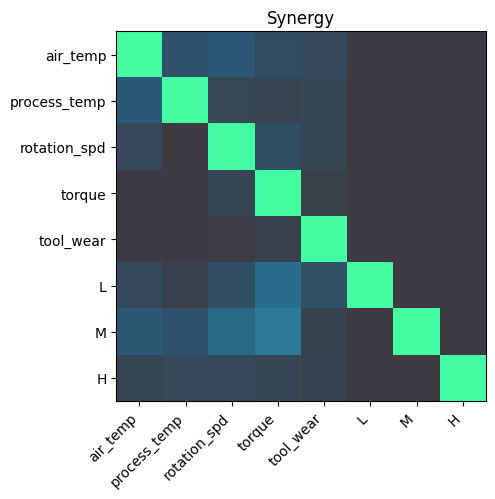

In [30]:
synergy_matrix = model_inspector.feature_synergy_matrix(clustered=False)
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy")

In [31]:
# https://stackoverflow.com/questions/76138915/subfigure-object-has-no-attribute-cachedrenderer
# https://github.com/matplotlib/matplotlib/issues/23173/

# ---------------------------------------------------------------------------
# AttributeError                            Traceback (most recent call last)
# Cell In[31], line 2
#       1 synergy_matrix = model_inspector.feature_synergy_matrix(clustered=False)
# ----> 2 MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy")

# File /opt/conda/lib/python3.10/site-packages/pytools/viz/_viz.py:300, in Drawer.draw(self, data, title)
#     295 if style._status != DrawingStyle._STATUS_STARTED:
#     296     raise AssertionError(
#     297         "DrawingStyle.start_drawing() not called from overloaded method"
#     298     )
# --> 300 self._draw(data)
#     302 style.finalize_drawing(**style_attributes)
#     303 # noinspection PyProtectedMember

# File /opt/conda/lib/python3.10/site-packages/pytools/viz/matrix/_matrix.py:363, in MatrixDrawer._draw(self, data)
#     361 def _draw(self, data: pd.DataFrame) -> None:
#     362     # draw the matrix
# --> 363     self.style.draw_matrix(data)

# File /opt/conda/lib/python3.10/site-packages/pytools/viz/matrix/_matrix.py:212, in MatrixMatplotStyle.draw_matrix(self, matrix)
#     207 n_columns = data.shape[1]
#     209 # only draw labels if a cell formatter is defined, and minimal height/width
#     210 # is available
#     211 if self.cell_formatter is not None and all(
# --> 212     size <= 1 for size in self.text_dimensions("0")
#     213 ):
#     214     # draw the axis to ensure we'll get correct coordinates
#     215     ax.draw(self.renderer)
#     217     # get the cell formatter as a local field

# File /opt/conda/lib/python3.10/site-packages/pytools/viz/_matplot.py:129, in MatplotStyle.text_dimensions(self, text, x, y, **kwargs)
#     124         y = y0
#     126 fig = ax.figure
#     128 extent = mt.Text(x, y, text, figure=fig, **kwargs).get_window_extent(
# --> 129     self.renderer
#     130 )
#     132 (x0, y0), (x1, y1) = ax.transData.inverted().transform(extent)
#     134 return abs(x1 - x0), abs(y1 - y0)

# File /opt/conda/lib/python3.10/site-packages/pytools/viz/_matplot.py:88, in MatplotStyle.renderer(self)
#      86 renderer = self._renderer
#      87 if renderer is None:
# ---> 88     self._renderer = renderer = get_renderer(self.ax.figure)
#      89 return renderer

# File /opt/conda/lib/python3.10/site-packages/matplotlib/tight_layout.py:206, in get_renderer(fig)
#     205 def get_renderer(fig):
# --> 206     if fig._cachedRenderer:
#     207         return fig._cachedRenderer
#     208     else:

# AttributeError: 'Figure' object has no attribute '_cachedRenderer'

# Global Explainability - Redundancy

AttributeError: 'Figure' object has no attribute '_cachedRenderer'

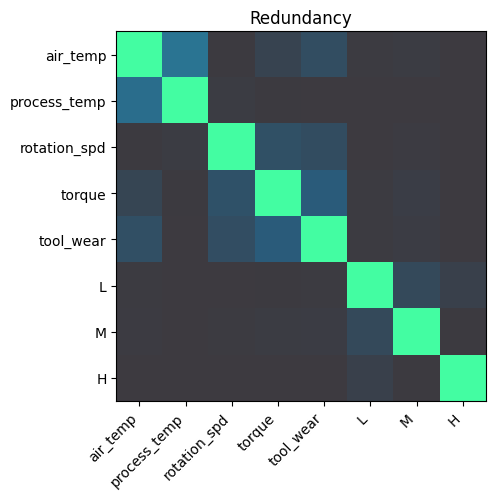

In [32]:
redundancy_matrix = model_inspector.feature_redundancy_matrix(clustered=False)
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy")

# Global Explainability - Feature clustering and importance

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().


AttributeError: 'Figure' object has no attribute '_cachedRenderer'

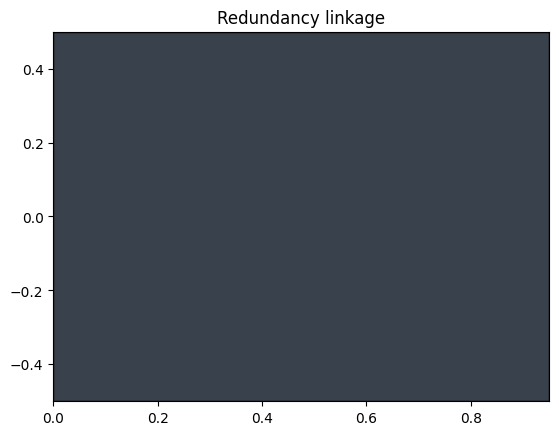

In [33]:
redundancy = model_inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(title="Redundancy linkage", data=redundancy)

# FACET univariate simulator

In [34]:
# bootstrap cross validation
# create a crossfit from our previous LearnerRanker best model 
# to perform the simulation so we can 'quantify the uncertainty' by using 'bootstrap confidence intervals'

# create a bootstrap CV crossfit for simulation using best model
boot_crossfit = LearnerCrossfit(
    pipeline=model_ranker.best_model_,
    cv=BootstrapCV(n_splits=1000, random_state=42),
    n_jobs=-3,
    verbose=0,
).fit(sample=machine_obs)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[03:17:50] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:17:51] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:17:52] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:17:52] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:17:53] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:17:54] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:17:55] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:17:55] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:17:56] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:17:57] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:17:57] WARNING: ../src/learner.cc:767: 
Parameters: { "m

[03:23:06] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:23:06] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:23:07] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:23:08] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:23:08] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:23:09] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:23:10] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:23:10] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:23:11] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:23:12] WARNING: ../src/learner.cc:767: 
Parameters: { "min_data_in_leaf" } are not used.

[03:23:12] WARNING: ../src/learner.cc:767: 
Parameters: { "m

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


AttributeError: 'Figure' object has no attribute '_cachedRenderer'

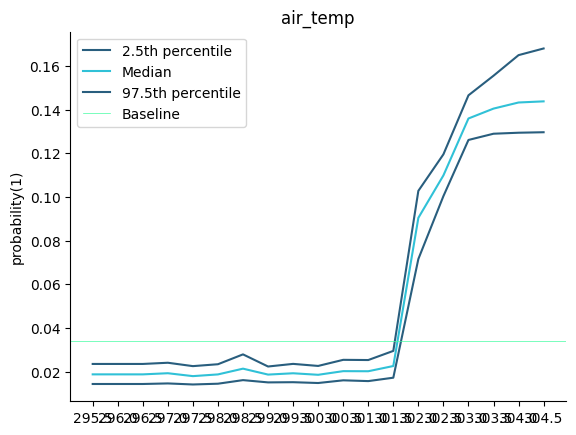

In [35]:
# set-up and run a simulation
list_sim_feature = ['air_temp', 'process_temp', 'rotation_spd', 'torque', 'tool_wear', 'L', 'M', 'H']
def reusable_simulator(SIM_FEATURE):
    temp_bins = ContinuousRangePartitioner()
    temp_simulator = UnivariateProbabilitySimulator(crossfit=boot_crossfit, n_jobs=3)
    temp_simulation = temp_simulator.simulate_feature(feature_name=SIM_FEATURE, partitioner=temp_bins)
    
    # plot how different values of the selected feature affects the target
    return SimulationDrawer().draw(data=temp_simulation, title=SIM_FEATURE)

for SIM_FEATURE in list_sim_feature:
    reusable_simulator(SIM_FEATURE)

AttributeError: 'Figure' object has no attribute '_cachedRenderer'

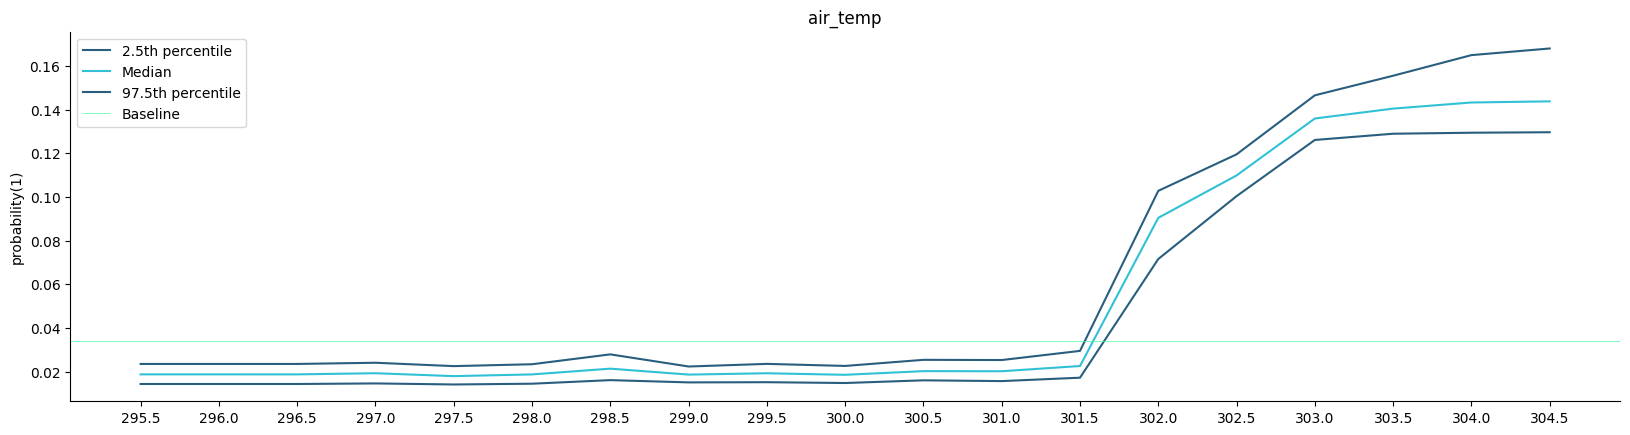

In [36]:
# list_sim_feature = ['air_temp', 'process_temp', 'rotation_spd', 'torque', 'tool_wear', 'L', 'M', 'H']
# 8 elements 

plt.figure().set_figwidth(20)
reusable_simulator(list_sim_feature[0])

Machine Failure from air_temp (K)
* from above, air_temp less than 301.5 have a base machine failure rate of up to 3%
* air_temp from 301.5 and onwards have a base machine failure rate of up to 18%

AttributeError: 'Figure' object has no attribute '_cachedRenderer'

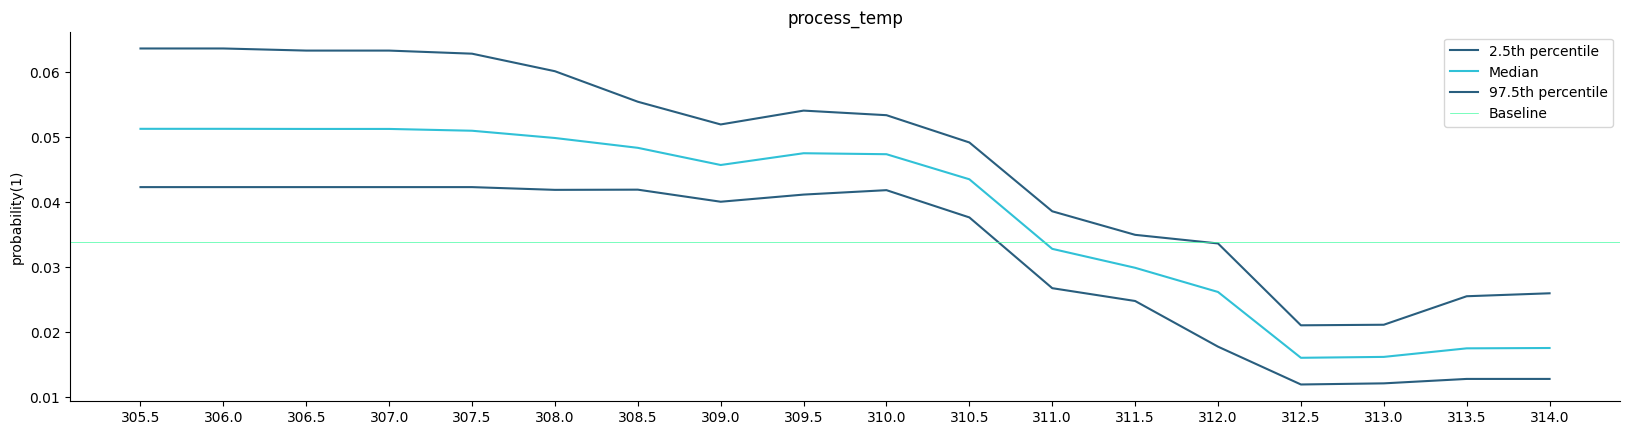

In [37]:
# list_sim_feature = ['air_temp', 'process_temp', 'rotation_spd', 'torque', 'tool_wear', 'L', 'M', 'H']
# 8 elements

plt.figure().set_figwidth(20)
reusable_simulator(list_sim_feature[1])

Machine Failure from process_temp (K)
* from above, process_temp from 312.5 and onwards have a base machine failure rate of up to 3%
* process_temp less than 312.5 have a base machine failure rate of up to 7%

AttributeError: 'Figure' object has no attribute '_cachedRenderer'

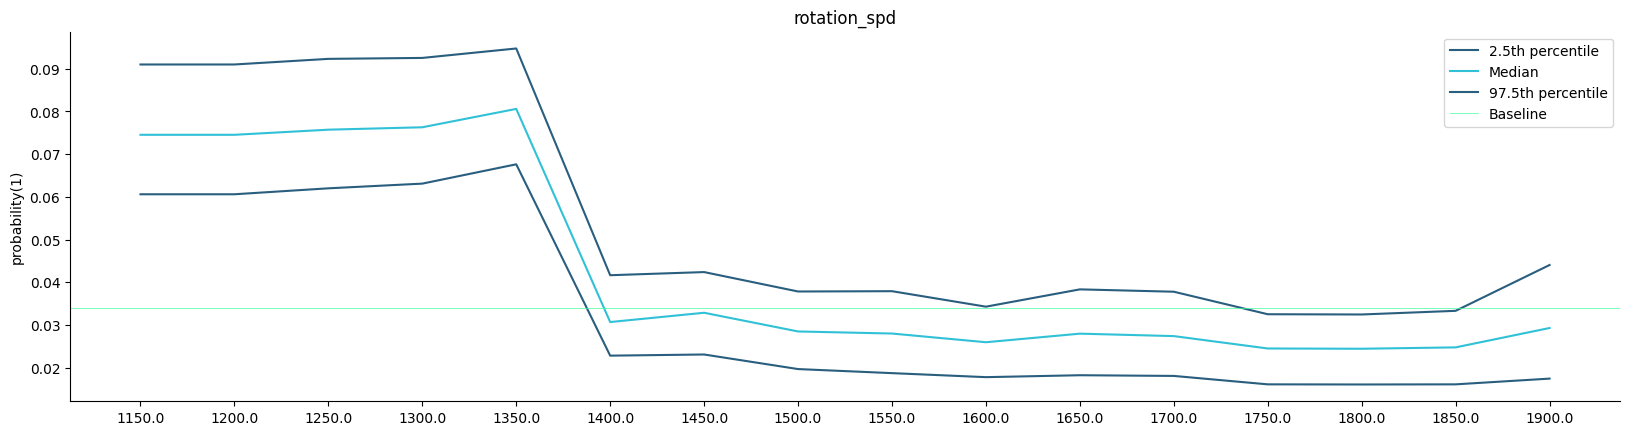

In [38]:
# list_sim_feature = ['air_temp', 'process_temp', 'rotation_spd', 'torque', 'tool_wear', 'L', 'M', 'H']
# 8 elements

plt.figure().set_figwidth(20)
reusable_simulator(list_sim_feature[2])

Machine Failure from rotation_spd (rpm)
* from above, rotation_spd from 1400 and onwards have a base machine failure rate of up to 5%
* rotation_spd less than 1400 have a base machine failure rate of up to 10%

In [39]:
# https://bcg-gamma.github.io/facet/apidoc/facet/simulation/viz/facet.simulation.viz.SimulationMatplotStyle.html#facet.simulation.viz.SimulationMatplotStyle
# https://bcg-gamma.github.io/pytools/apidoc/pytools/viz/pytools.viz.MatplotStyle.html#pytools.viz.MatplotStyle.renderer
# https://bcg-gamma.github.io/pytools/apidoc/pytools/viz/pytools.viz.MatplotStyle.html#pytools.viz.MatplotStyle.get_renderer
from pytools.viz import MatplotStyle
MatplotStyle.get_renderer()
# AttributeError: type object 'MatplotStyle' has no attribute 'get_renderer'

AttributeError: type object 'MatplotStyle' has no attribute 'get_renderer'

AttributeError: 'Figure' object has no attribute '_cachedRenderer'

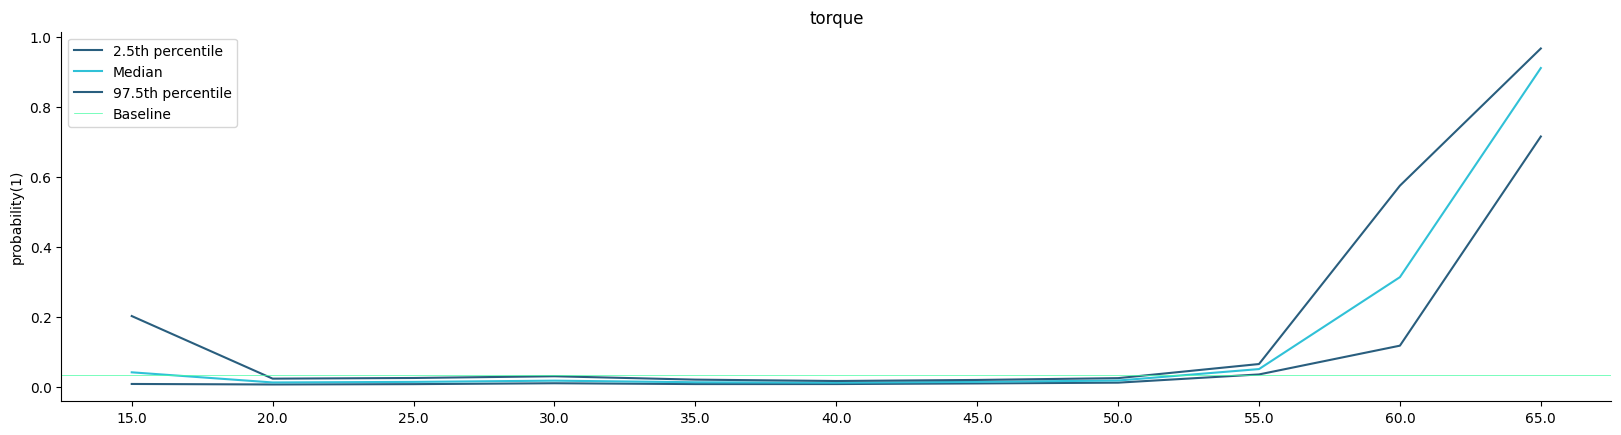

In [40]:
# list_sim_feature = ['air_temp', 'process_temp', 'rotation_spd', 'torque', 'tool_wear', 'L', 'M', 'H']
# 8 elements

plt.figure().set_figwidth(20)
reusable_simulator(list_sim_feature[3])

Machine Failure from torque (Nm)
* from above, torque from 20 to approx 55 have a low base machine failure rate of less than 0.025, or less than 2.5%
* torque less than 20 could have a base machine failure rate of up to 20%
  * there is a mixture of machines which are **truly idle and have lower torque**
  * with **machines which could be failing, and thus have lower torque => we are observing the symptom of machine failure**
* from torque 55 and onwards, base machine failure rate increases sharply, with the worst being 100% machine failure
* What we see here is that torque (angular rotation and acceleration) seems to be a good predictor for machine failure, at
  * low torque values - less than 20
  * high torque values - 55 and onwards

AttributeError: 'Figure' object has no attribute '_cachedRenderer'

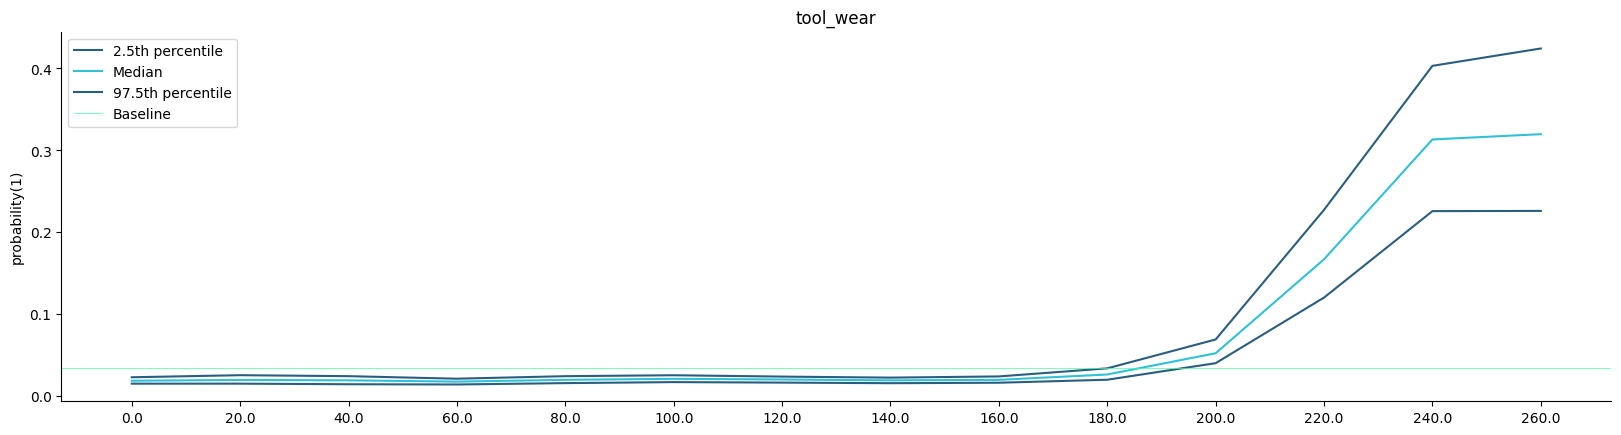

In [41]:
# list_sim_feature = ['air_temp', 'process_temp', 'rotation_spd', 'torque', 'tool_wear', 'L', 'M', 'H']
# 8 elements

plt.figure().set_figwidth(20)
reusable_simulator(list_sim_feature[4])

Machine Failure from tool_wear
* from above, tool_wear from 0 to approx 200 have a low base machine failure rate of less than 0.025, or less than 2.5%
* from tool_wear 200 and onwards, base machine failure rate increases to approx 3%

AttributeError: 'Figure' object has no attribute '_cachedRenderer'

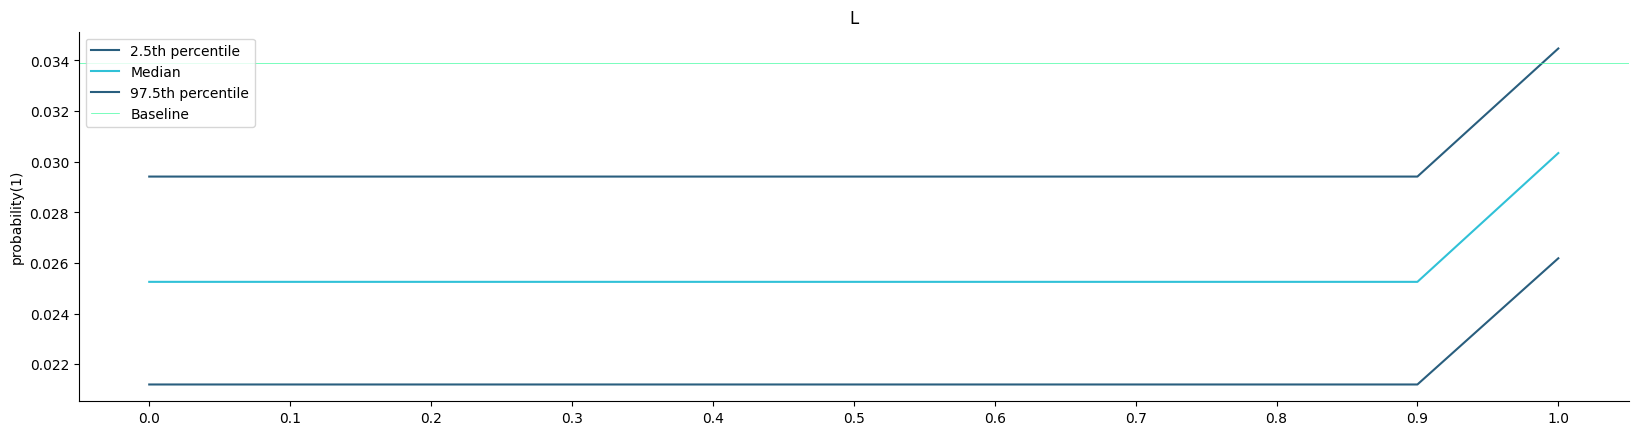

In [42]:
# list_sim_feature = ['air_temp', 'process_temp', 'rotation_spd', 'torque', 'tool_wear', 'L', 'M', 'H']
# 8 elements

plt.figure().set_figwidth(20)
reusable_simulator(list_sim_feature[5])

Machine Failure from 'L' quality product type
* from above, 90% of 'L' quality product types seem to have a base machine failure rate of 2.6%
* while 10% of 'L' quality product types seem to have a base machine failure rate of 3%

AttributeError: 'Figure' object has no attribute '_cachedRenderer'

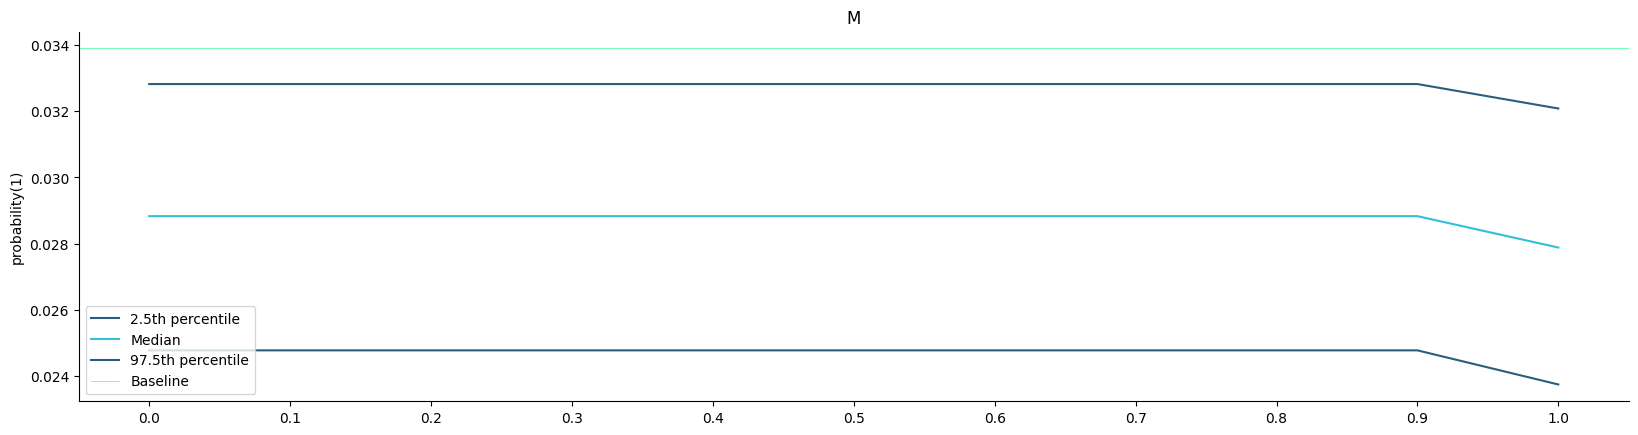

In [43]:
# list_sim_feature = ['air_temp', 'process_temp', 'rotation_spd', 'torque', 'tool_wear', 'L', 'M', 'H']
# 8 elements

plt.figure().set_figwidth(20)
reusable_simulator(list_sim_feature[6])

Machine Failure from 'M' quality product type
* from above, 90% of 'M' quality product types seem to have a base machine failure rate of 3%
* while 10% of 'M' quality product types seem to have a base machine failure rate of 2.4 to 3%

In [44]:
# list_sim_feature = ['air_temp', 'process_temp', 'rotation_spd', 'torque', 'tool_wear', 'L', 'M', 'H']
# 8 elements

plt.figure().set_figwidth(20)
# reusable_simulator(list_sim_feature[7]) 
# ValueError: arg step must be positive
reusable_simulator(list_sim_feature[-1])
# ValueError: arg step must be positive

# NOT SURE WHAT THE ISSUE IS HERE
# MAYBE STEP SIZE IS '0', so there is no plot?

ValueError: arg step must be positive

<Figure size 2000x480 with 0 Axes>

In [1]:
### vikram's ####

import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import warnings



# Load the dataset
df = pd.read_csv("ai4i2020.csv")

# Drop the "UDI" and "Product ID" columns
df = df.drop(["UDI", "Product ID"], axis=1)

# Perform one-hot encoding on the "Type" column
df_encoded = pd.get_dummies(df, columns=["Type"])

# Separate the target variable
target = df_encoded["Machine failure"]
features = df_encoded.drop("Machine failure", axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the classifiers
classifiers = {
    "KNN": KNeighborsClassifier(),
    "DT": DecisionTreeClassifier(max_depth=5),
    "RF": RandomForestClassifier(n_estimators=100),
    "LR": LogisticRegression()
}

# Define the parameter ranges for the learning curves
param_ranges = {
    "KNN": np.linspace(1, 50, 10).astype(int),
    "DT": np.linspace(1, 50, 10).astype(int),
    "RF": np.linspace(1, 50, 10).astype(int),
    "LR": np.linspace(0.1, 1.0, 10)
}

# Compute the learning curves for each classifier
for name, clf in classifiers.items():
    train_sizes, train_scores, test_scores = learning_curve(
        clf, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy', n_jobs=-1
    )
##    name = "Decision Tree"
#    print(f"Results for {name}")

 #   print(f"Training scores: {train_scores.mean(axis=1)}")
 #   print(f"Testing scores: {test_scores.mean(axis=1)}\n")
    warnings.filterwarnings('ignore')

/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/spartan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("ai4i2020.csv")

# Drop the "UDI" and "Product ID" columns
df = df.drop(["UDI", "Product ID"], axis=1)

# Perform one-hot encoding on the "Type" column
df_encoded = pd.get_dummies(df, columns=["Type"])

# Separate the target variable
target = df_encoded["Machine failure"]
features = df_encoded.drop("Machine failure", axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Generate classification report for each model
for name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=['No Failure', 'Failure'])

    # Print the classification report
    print(f'{name} Performance Metrics:')
    print(report)


KNN Performance Metrics:
              precision    recall  f1-score   support

  No Failure       0.97      1.00      0.98      1939
     Failure       0.57      0.13      0.21        61

    accuracy                           0.97      2000
   macro avg       0.77      0.56      0.60      2000
weighted avg       0.96      0.97      0.96      2000

Decision Tree Performance Metrics:
              precision    recall  f1-score   support

  No Failure       1.00      1.00      1.00      1939
     Failure       0.95      0.97      0.96        61

    accuracy                           1.00      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       1.00      1.00      1.00      2000

Logistic Regression Performance Metrics:
              precision    recall  f1-score   support

  No Failure       1.00      1.00      1.00      1939
     Failure       1.00      0.89      0.94        61

    accuracy                           1.00      2000
   macro avg       1.00    

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
df = pd.read_csv("ai4i2020.csv")

# Drop the "UDI" and "Product ID" columns
df = df.drop(["UDI", "Product ID"], axis=1)

# Perform one-hot encoding on the "Type" column
df_encoded = pd.get_dummies(df, columns=["Type"])

# Separate the target variable
target = df_encoded["Machine failure"]
features = df_encoded.drop("Machine failure", axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the SVM model
model = SVC(kernel='linear', C=1)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


Accuracy: 0.999
Precision: 1.0
Recall: 0.9672131147540983
F1 score: 0.9833333333333333
